In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
%matplotlib inline

import sklearn
from sklearn.datasets import fetch_california_housing

plt.rcParams['font.size'] = 14

In [2]:
# Download data

tmp = sklearn.datasets.fetch_california_housing()

num_samples   = tmp['data'].shape[0]
feature_names = tmp['feature_names']
y = tmp['target']
X = tmp['data']

data = {}
for n, feature in enumerate(feature_names):
    data[feature] = tmp['data'][:,n]

In [3]:
# Create stumps

# bin the data by proportion, 10% in each bin
bins = {}
bin_idx = (np.arange(0,1.1,0.1)*num_samples).astype(np.int16)
bin_idx[-1] = bin_idx[-1]-1
for feature in (feature_names):
    bins[feature] = np.sort(data[feature])[bin_idx]

# decision stumps as weak classifiers
# 0 if not in bin, 1 if in bin
stumps = {}
for feature in feature_names:
    stumps[feature] = np.zeros([num_samples,len(bins[feature])-1])
    for n in range(len(bins[feature])-1):
        stumps[feature][:,n] = data[feature]>bins[feature][n]

# stack the weak classifiers into a matrix
H = np.hstack([stumps[feature] for feature in feature_names])
H = np.hstack([np.ones([num_samples,1]),H])
# prepare the vector for storing weights
alphas = np.zeros(H.shape[1])

### AdaBoost

In [4]:
num_iterations = 30
MSE = np.zeros(num_iterations) # track mean square error

In [5]:
for iteration in range(num_iterations):
    f = np.dot(H,alphas)
    r = y-f; MSE[iteration] = np.mean(r**2)
    idx = np.argmax(np.abs(np.dot(H.T,y-np.dot(H,alphas))))
    alphas[idx] = alphas[idx] + np.dot(H[:,idx],r)/np.sum(H[:,idx]**2,axis=0)

In [6]:
alphasf = {}
start = 1
for feature in feature_names:
    alphasf[feature] = alphas[start:(start+stumps[feature].shape[1])]
    start = start + stumps[feature].shape[1]
alphasf['mean'] = alphas[0]

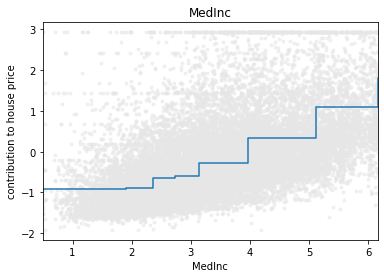

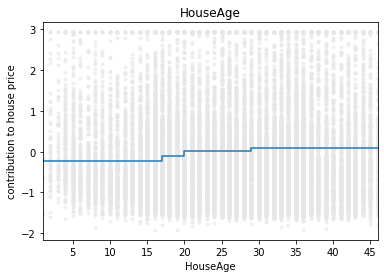

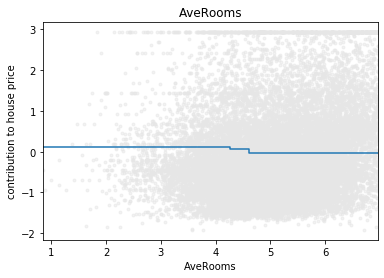

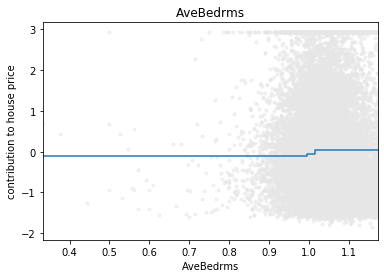

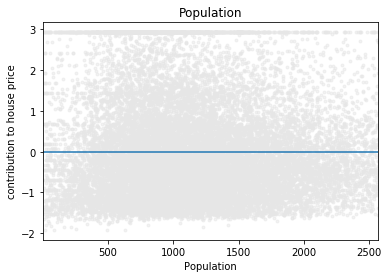

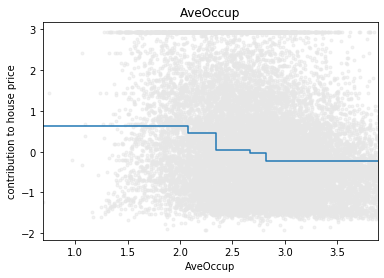

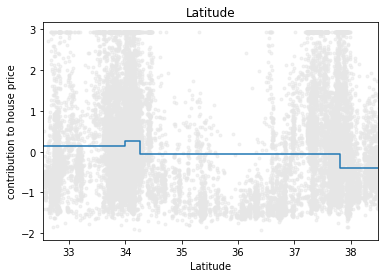

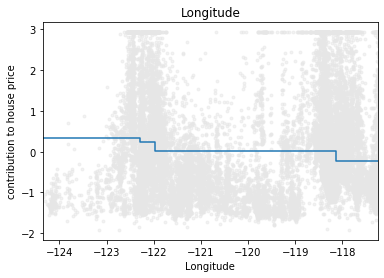

In [9]:
for feature in feature_names:
    plt.close("all")
    plt.plot(data[feature],y-np.mean(y),'.',alpha=0.5,color=[0.9,0.9,0.9])
    pltx = np.hstack([bins[feature][0],np.tile(bins[feature][1:-1],[2,1]).T.reshape(-1),bins[feature][-1]])
    plty = np.tile(np.cumsum(alphasf[feature]),[2,1]).T.reshape(-1)-np.mean(np.cumsum(alphasf[feature]))
    plt.plot(pltx,plty)
    plt.title(feature)
    plt.xlim([bins[feature][0],bins[feature][-2]])
    plt.xlabel(feature)
    plt.ylabel('contribution to house price')
    plt.show()

In [31]:
print('Variable Importance')

for feature_no, feature in enumerate(feature_names):
    H2 = np.array(H)
    H2[np.random.permutation(num_samples),(feature_no*10+1):((feature_no+1)*10+1)] = H[:,(feature_no*10+1):((feature_no+1)*10+1)]
    f = np.dot(H2,alphas)
    r = y-f;
    print(feature,', error: %.2f'%(np.mean(r**2)))

Variable Importance
MedInc , error: 1.94
HouseAge , error: 0.53
AveRooms , error: 0.51
AveBedrms , error: 0.50
Population , error: 0.49
AveOccup , error: 0.67
Latitude , error: 0.62
Longitude , error: 0.58


In [32]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence

In [33]:
clf = GradientBoostingRegressor(loss="ls")
clf.fit(X,y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

//anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function plot_partial_dependence is deprecated; The function ensemble.plot_partial_dependence has been deprecated in favour of sklearn.inspection.plot_partial_dependence in  0.21 and will be removed in 0.23.
  warnings.warn(msg, category=DeprecationWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function partial_dependence is deprecated; The function ensemble.partial_dependence has been deprecated in favour of inspection.partial_dependence in 0.21 and will be removed in 0.23.
  warnings.warn(msg, category=DeprecationWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function partial_dependence is deprecated; The function ensemble.partial_dependence has been deprecated in favour of inspection.partial_dependence in 0.21 and will be removed in 0.23.
  warnings.warn(msg, category=DeprecationWarn

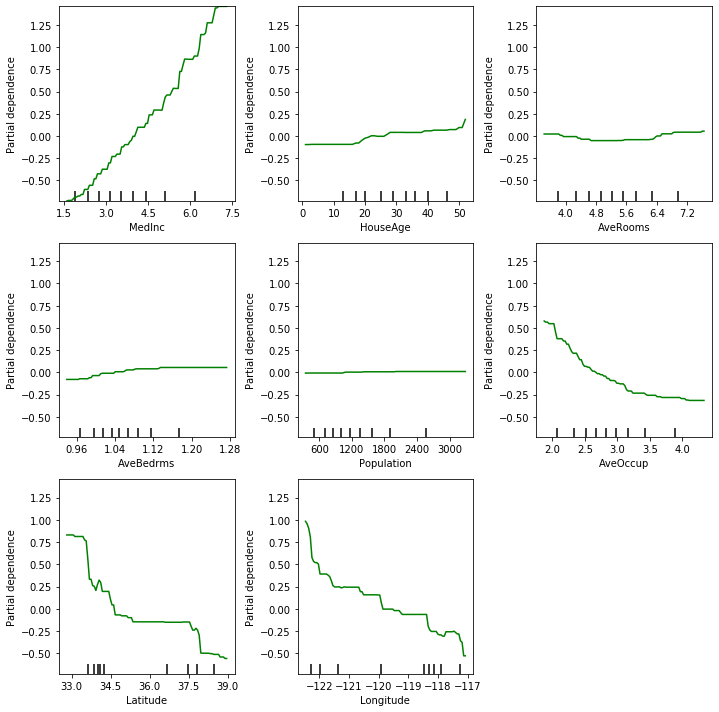

In [34]:
plt.close("all")
plt.figure(figsize=[10,10])
ax = plt.gca()
plot_partial_dependence(clf, X, feature_names, feature_names, n_cols=3, ax=ax) 
plt.tight_layout()
plt.show()

In [35]:
from sklearn.linear_model import LinearRegression

In [36]:
clf2 = LinearRegression()
clf2.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [37]:
np.mean((y-clf2.predict(X))**2)

0.5243209861846071

In [38]:
np.mean((y-clf.predict(X))**2)

0.2618843196589294